# 第一步：加载库

In [6]:
%matplotlib inline

import numpy as np
import dicom
import glob
from matplotlib import pyplot as plt
import os
import cv2
import mxnet as mx
import pandas as pd

In [7]:
from sklearn import cross_validation

/usr/local/lib/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
import xgboost as xgb
import time
import datetime

# 第二步：设计整体框架

1. 数据读取与特征提取  
 1.1 加载数据  
 1.2 特征提取  
2. 训练分类器并预测测试集

代码框架如下：

In [59]:
if __name__ == '__main__':
    # 初始化
    dicom_data_below_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*'
    save_feature = True
    feature_save_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/npy_files_v2/'
    extractor_prefix = '/home/yuens/Downloads/code/mxnet_inference/resnet/resnet-50'
    extractor_epoch = 0
    
    # 特征提取
    # 单样本时间在50s左右
    calc_features(dicom_data_below_path,\
                  save_feature,
                  feature_save_path,\
                  extractor_prefix,\
                  extractor_epoch)
    #import pandas as pd
    #import numpy as np
    #make_submit()

/usr/local/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


patient idx start from 1.
2017-03-23 23:37:24 1th/1595 patient calc feats:30.0410, save feats:0.0243
2017-03-23 23:37:54 2th/1595 patient calc feats:59.7171, save feats:0.0347
2017-03-23 23:38:54 3th/1595 patient calc feats:62.2291, save feats:0.0060
2017-03-23 23:39:56 4th/1595 patient calc feats:27.1395, save feats:0.0047
2017-03-23 23:40:23 5th/1595 patient calc feats:22.3278, save feats:0.0047
2017-03-23 23:40:45 6th/1595 patient calc feats:27.0971, save feats:0.0067
2017-03-23 23:41:13 7th/1595 patient calc feats:27.2463, save feats:0.0056
2017-03-23 23:41:40 8th/1595 patient calc feats:28.1170, save feats:0.0046
2017-03-23 23:42:08 9th/1595 patient calc feats:29.0460, save feats:0.0049
2017-03-23 23:42:37 10th/1595 patient calc feats:24.1482, save feats:0.0056
2017-03-23 23:43:01 11th/1595 patient calc feats:17.9256, save feats:0.0039
2017-03-23 23:43:19 12th/1595 patient calc feats:51.8249, save feats:0.0053
2017-03-23 23:44:11 13th/1595 patient calc feats:20.0661, save feats:0.

In [60]:
42681.5580/3600

11.855988333333332

# 第三步：数据读取与特征提取

首先给出**数据读取与特征提取的主要函数**：

In [58]:
# 加载dicom原始数据并预处理
# 根据特征提取器，计算dicom数据特征
def calc_features(dicom_data_below_path, save_feature, feature_save_path, extractor_prefix, extractor_epoch=0):
    # 检查特征保存路径是否存在
    if not os.path.isdir(feature_save_path):
        os.mkdir(feature_save_path)
        
    # 加载网络模型和参数
    net = get_extractor(model_prefix_path=extractor_prefix,\
                        model_epoch=extractor_epoch)
    
    # 加载所有病人路径
    patients_folder_path = glob.glob(dicom_data_below_path)
    
    
    # 逐一读取病人dicom数据，预处理，提取特征
    print("patient idx start from 1.")
    start_calc_features = time.time()
    for idx in xrange(len(patients_folder_path)):
        
        # 打印日志并计时
        time_stamp = datetime.datetime.now() 
        print("{} {}th/{} patient".format(time_stamp.strftime('%Y-%m-%d %H:%M:%S'), idx+1, len(patients_folder_path))),
        start_extract = time.time()
        
        # 读取dicom数据和预处理并提取特征
        folder_path = patients_folder_path[idx]
        patient_id = folder_path[folder_path.find("stage1/")+len("stage1/"):]
        patient_4d = get_composed_patient_4d(folder_path,\
                                             resize_tuple=(224, 224),\
                                             dx=40,\
                                             ds=512)
        feats = net.predict(patient_4d)
        
        # 计时并保存特征，打印特征计算和保存时间
        finish_extract = time.time()
        if save_feature:
            np.save(feature_save_path+patient_id+".npy", feats)
        finish_save_feature = time.time()
        calc_feats_times = finish_extract - start_extract
        save_feats_times = finish_save_feature - finish_extract
        print("calc feats:{:.4f}, save feats:{:.4f}".format(calc_feats_times, save_feats_times))
        
    # 打印日志并计时
    finish_calc_features = time.time()
    calc_features_4_all_patients = finish_calc_features - start_calc_features
    print("calculate and save features time elapse:{:.4f}".format(calc_features_4_all_patients))

下面这些函数都是给**calc_features**这个函数，提供支援的（内部调用的）。

In [42]:
# 加载特征提取器模型
def get_extractor(model_prefix_path, model_epoch=0):
    model = mx.model.FeedForward.load(prefix=model_prefix_path,\
                                      epoch=model_epoch,\
                                      ctx=mx.cpu(),\
                                      numpy_batch_size=1)
    # model.symbol.get_internals: 
    # Get a new grouped symbol whose output contains internal outputs of this symbol.
    fea_symbol = model.symbol.get_internals()["flatten0_output"]
    feature_extractor = mx.model.FeedForward(ctx=mx.cpu(), symbol=fea_symbol, numpy_batch_size=64,
                                             arg_params=model.arg_params, aux_params=model.aux_params,
                                             allow_extra_params=True)

    return feature_extractor

In [43]:
# 对当前路径的病人所有图像合成三通道的图像
# 最终得到 n 张三通道图像，即四维numpy数组
def get_composed_patient_4d(patient_path, resize_tuple=(224, 224), dx=40, ds=512):
    # 读取病人图像数据为numpy数组
    patient_img_np = get_patient_img_np(patient_path)
    #patient_img_np[patient_img_np == -2000] = 0
    # 设定扫描外围的像素值为0
    # 截距通常为-1024，所以空气约为0
    # image[image == -2000] = 0
    outside_img = patient_img_np.min()
    patient_img_np[patient_img_np == outside_img] = 0
    
    # patient_4d:四维numpy数组[n, 3, x, y]，有n张三通道的图
    # 通过dx和ds对图像上下左右的空气边沿去掉，这两个值是人为定义的
    patient_4d = []
    dx = dx
    ds = ds
    
    # 根据当前病人的所有图像切片合成三通道数据
    for comp_idx in xrange(0, patient_img_np.shape[0] - 3, 3):
        # 每个comp_3channel_img_list是三幅2D图像
        # 即这个list中有三个元素，每个元素都是一个2D图像(一个通道)
        comp_3channel_img_list = []
        for channel_idx in xrange(3):
            img = patient_img_np[comp_idx + channel_idx]
            # 这部分包含两个步骤：去均值(0.25)，并规范化，
            # 之后将值映射到[0, 255]区间上
            img = 255.0 / np.amax(img) * (1-0.25) * img
            # 直方图均衡化
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img[dx: ds - dx, dx: ds - dx]
            # 我加入下面这行将图像上面几行的冗余去除
            img = img[2*dx:, :]
            img = cv2.resize(img, resize_tuple)
            comp_3channel_img_list.append(img)
            
        # 每个comp_3channel_img_list是三幅2D图像把结果追加保存到patient_4d列表
        # comp_3channel_img_list是3D的
        # patient_4d是4D的(第comp_idx捆三张打包，三张打包中的第channel_idx张，
        # 第channel_idx张的第k行，第j张的第m列)
        comp_3channel_img_list = np.array(comp_3channel_img_list)
        patient_4d.append(np.array(comp_3channel_img_list))

    # 整个batch再次转化为numpy
    patient_4d = np.array(patient_4d)
    return patient_4d

In [44]:
# 读取当前病人的原始dicom数据路径
# 返回该病人所有CT图像numpy格式数据
def get_patient_img_np(patient_path):
    slices = [dicom.read_file(patient_path + '/' + s) for s in os.listdir(patient_path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [81]:
patient_4d = get_composed_patient_4d("/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/c0f2e3b499d10d147892579d0ad71321")
print patient_4d.shape

(57, 3, 224, 224)


255
0


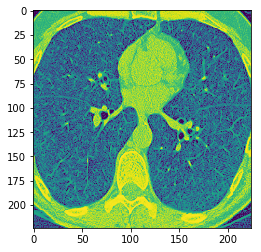

(224, 224)


In [100]:
print patient_4d[0].max()
print patient_4d[0].min()
plt.figure(1)
plt.imshow(patient_4d[30][1], )
plt.show()

print patient_4d[30][1].shape

In [103]:
from scipy.misc import imshow
%matplotlib inline

In [106]:
imshow(patient_4d[30])

In [109]:
data = np.reshape(patient_4d[30], (3, 224, 224))
print data.shape
#plt.imshow(data)

(3, 224, 224)


# 第四步：训练分类器和预测

函数如下：

In [8]:
def make_submit(train_data_path, feature_path, sample_submission_path, submission_save_path):    
    # 训练分类器
    clf = train_xgboost(train_data_path, feature_path)
    
    # 取出测试集数据做预测
    df = pd.read_csv(sample_submission_path)
    x = np.array([np.mean(np.load(feature_path + '%s.npy' % str(id)), axis=0) for id in df['id'].tolist()])
    pred = clf.predict(x)

    # 将结果写入文件准备提交
    df['cancer'] = pred
    df.to_csv(submission_save_path, index=False)
    print(df.head())

In [62]:
def train_xgboost(train_data_path, feature_path):
    import time
    df = pd.read_csv(train_data_path)
    print(df.head())
    
    x = np.array([np.mean(np.load(feature_path + '%s.npy' % str(id)),\
                          axis=0) for id in df['id'].tolist()]\
                )
    
    y = df['cancer'].as_matrix()

    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
                                                                   test_size=0.20)#0.20

    clf = xgb.XGBRegressor(max_depth=1,#10
                           n_estimators=20500,
                           min_child_weight=15,#9
                           learning_rate=0.00750,
                           nthread=8,
                           subsample=0.80,#0.8
                           colsample_bytree=0.80,
                           seed=4242)

    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)],\
            verbose=True,\
            eval_metric='logloss',\
            early_stopping_rounds=300)
    # eval_metric='logloss' or 'error' 
    
    return clf

In [63]:
## 初始化
train_data_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1_labels.csv'
feature_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/npy_files_v2/'
sample_submission_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1_sample_submission.csv'
submission_save_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/[mxnet+xgb-v2]submit_maxdepth_1_minChildWeight_15_earlystopping_300_lr_0.00750.csv'

# 训练分类器
# 预测测试样本并保存
make_submit(train_data_path,\
            feature_path,\
            sample_submission_path,\
            submission_save_path)

                                 id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1
[0]	validation_0-logloss:0.691284
Will train until validation_0-logloss hasn't improved in 300 rounds.
[1]	validation_0-logloss:0.689541
[2]	validation_0-logloss:0.68785
[3]	validation_0-logloss:0.686218
[4]	validation_0-logloss:0.684491
[5]	validation_0-logloss:0.682823
[6]	validation_0-logloss:0.681267
[7]	validation_0-logloss:0.679643
[8]	validation_0-logloss:0.678071
[9]	validation_0-logloss:0.6766
[10]	validation_0-logloss:0.675153
[11]	validation_0-logloss:0.673692
[12]	validation_0-logloss:0.672253
[13]	validation_0-logloss:0.670984
[14]	validation_0-logloss:0.669509
[15]	validation_0-logloss:0.668116
[16]	validation_0-logloss:0.666574
[17]	validation_0-logloss:0.665322
[18]	validation_0-logloss:0.663942
[19]	validation

In [15]:
model_prefix = 

print glob.glob(dicom_data_below_path)

['/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0030a160d58723ff36d73f41b170ec21', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/003f41c78e6acfa92430a057ac0b306e', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/006b96310a37b36cccb2ab48d10b49a3', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/008464bb8521d09a42985dd8add3d0d2', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0092c13f9e00a3717fdc940641f00015', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/024efb7a1e67dc820eb61cbdaa090166', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0257df465d9e4150adef13303433ff1e', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026470d51482c93efc18b9803159c960', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0268f3a7a17412178cfb039e71799a80', '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026be5d5e652b6a7488669d884ebe297', '/media/y